In [1]:
## run this cell only if using colab
from google.colab import drive
drive.mount('/content/drive')
    
import os
os.chdir('/content/drive/MyDrive/UCLA/ECE 247/ECE247-project')

ModuleNotFoundError: No module named 'google.colab'

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## strange error only on macOS apparently 
## https://github.com/dmlc/xgboost/issues/1715
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
## get data, just Close values
import readcsv
data_raw = readcsv.get_data(cols=['Close'], verbose=False).astype(np.float32)
print(data_raw.shape)

(18628, 54)


In [3]:
## scale all data into interval [0, 1]
import sklearn.preprocessing
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(data_raw)
data_raw = scaler.transform(data_raw)

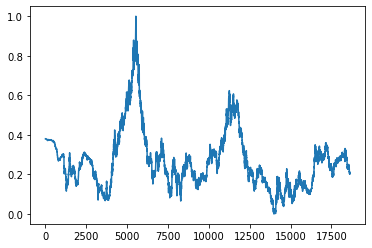

In [4]:
## visualize data, just to make sure things are OK
plt.plot(data_raw[:, 0])
plt.show()

In [5]:
## test: fit on cosine
#data = np.cos(2*np.pi*np.arange(18000)/25).reshape(-1, 1)
#print(data.shape)

In [6]:
from rnn_helper import *
#test_rnn_helper()

# Predict next day
Given 30-day history of USD-EUR closing, predict next day closing price.
Should expect good performance since linear regression is pretty good at this.

In [7]:
## ===== learning parameters ========================
learn_window = np.arange(30) ## learn from past 30 days
predict_window = np.arange(1) ## predict next day
## ==================================================

In [8]:
## split into training and testing sets
## take 100 random windows, 50 for validation and 50 for testing
## all other non-overlapping data goes to testing.

data = data_raw[:, 0:1] ## take only USD-EUR Close values
print("Data shape:", data.shape)

N, C = data.shape
L, P = len(learn_window), len(predict_window)
Lcap, Pcap = int(np.max(learn_window))+1, int(np.max(predict_window))+1
M = N - Lcap - Pcap

np.random.seed(999)
test_starts = np.random.randint(0, M, 50)
val_starts = np.random.randint(0, M, 50)

mask = np.ones(N)
for i in test_starts:
    mask[i+learn_window] = 0
for i in val_starts:
    mask[i+learn_window] = 0 
mask[np.arange(M, N)] = 0
train_starts = np.flatnonzero(mask)

print("Training size:", train_starts.shape[0])
print("Validation size:", val_starts.shape[0], "...", val_starts[:5])
print("Test size:", test_starts.shape[0], "...", test_starts[:5])

Data shape: (18628, 1)
Training size: 15747
Validation size: 50 ... [ 1286  7103  9451 16503 13300]
Test size: 50 ... [12636 13157 16865  5832  8417]


In [9]:
## generate testing and validation data
G = generate_all_regression(data, 50, learn_window, predict_window, val_starts)
X_val, y_val = next(G)

G = generate_all_regression(data, 50, learn_window, predict_window, test_starts)
X_test, y_test = next(G)

In [10]:
## ===== model hyperparameters ======================
batch_size = 50
initial_learning_rate = 1e-3
decay_steps = 300
decay_rate = 0.9
callback = keras.callbacks.ModelCheckpoint(monitor='mse', filepath='1d-LSTM.h5',
                                           save_best_only=True, mode='min')
## ==================================================

np.random.seed(0) ## for reproducability
tf.random.set_seed(0)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, 
    decay_steps=decay_steps, 
    decay_rate=decay_rate)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model_1d = models.Sequential()
#model_1d.add(layers.LSTM(100, input_shape=(L, C)))
model_1d.add(layers.GRU(100, input_shape=(L, C)))
model_1d.add(layers.Dense(P))
model_1d.compile(optimizer=opt, loss='mse', metrics=['mse'])
model_1d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100)               30900     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________


In [14]:
## train on one data point as test
G = generate_batches_regression(data, 1, learn_window, predict_window, train_starts)
X, y = next(G)

model_1d.fit(X, y, batch_size=1)
model_1d.evaluate(X, y, batch_size=1)

Train on 1 samples
1/1 [==============================] - 1s 1s/sample - loss: 0.0432 - mse: 0.0432


[0.04323010519146919, 0.043230105]

In [15]:
## train!
G = generate_batches_regression(data, batch_size, learn_window, predict_window, train_starts)

## GRU
model_1d.fit(G, steps_per_epoch=300, epochs=30, validation_data=(X_val, y_val), callbacks=[callback])

Train for 300 steps, validate on 50 samples
Epoch 1/30
300/300 [==============================] - 40s 132ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 8.3090e-05 - val_mse: 8.3090e-05
Epoch 2/30
300/300 [==============================] - 38s 125ms/step - loss: 5.4990e-05 - mse: 5.4990e-05 - val_loss: 7.2510e-05 - val_mse: 7.2510e-05
Epoch 3/30
300/300 [==============================] - 32s 108ms/step - loss: 5.1569e-05 - mse: 5.1569e-05 - val_loss: 5.8463e-05 - val_mse: 5.8463e-05
Epoch 4/30
300/300 [==============================] - 47s 157ms/step - loss: 4.5494e-05 - mse: 4.5494e-05 - val_loss: 5.8160e-05 - val_mse: 5.8160e-05
Epoch 5/30
300/300 [==============================] - 39s 129ms/step - loss: 4.5183e-05 - mse: 4.5183e-05 - val_loss: 5.2366e-05 - val_mse: 5.2366e-05
Epoch 6/30
300/300 [==============================] - 50s 167ms/step - loss: 4.1857e-05 - mse: 4.1857e-05 - val_loss: 4.9568e-05 - val_mse: 4.9568e-05
Epoch 7/30
300/300 [==============================] - 28s 

Comment for GRU: The validation loss is slightly less than training loss. This is because since our dataset is non-uniform in time, the training data is just harder to model than the validation data. At least, this assures us that our model is not overfitting. Also, the training loss is a running average over the epoch, so it is over-estimated in the beginning.

Comment for LSTM: takes more epochs to train

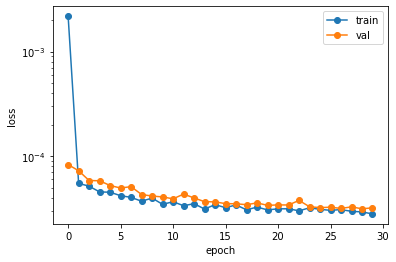

In [16]:
train_loss = model_1d.history.history['loss']
val_loss = model_1d.history.history['val_loss']

plt.plot(train_loss, '-o', label='train')
plt.plot(val_loss, '-o', label='val')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()
plt.show()

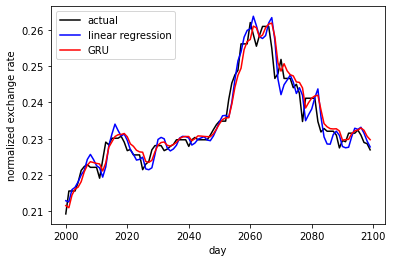

In [12]:
## visualize predictions
import sklearn.linear_model
import sklearn.preprocessing

starts = np.arange(2000, 2100)

model_1d.load_weights('kevin-models/1d-GRU.h5')

G = generate_all_regression(data, len(starts), learn_window, predict_window, starts)
X, y_actual = next(G)
y_predict = model_1d.predict(X)

## linear regression predictions

lin_learn_window = np.arange(5)
lin_Lcap = 5
lin_y_predict = np.zeros(len(starts))
for count, i in enumerate(starts):
    lin_x_learn = (25+i+lin_learn_window).reshape(-1, 1)
    lin_x_predict = (25+i+lin_Lcap+predict_window).reshape(-1, 1)
    lin_y_learn = data[lin_x_learn[:, 0]]

    model = sklearn.linear_model.LinearRegression()
    model.fit(lin_x_learn, lin_y_learn)
    lin_y_predict[count] = model.predict(lin_x_predict)

plt.plot(starts, y_actual[:, 0], label='actual', color='black')
plt.plot(starts, lin_y_predict, label='linear regression', color='blue')
plt.plot(starts, y_predict[:, 0], label='GRU', color='red')
plt.ylabel('normalized exchange rate')
plt.xlabel('day')
plt.legend()
plt.show()

In [13]:
y = model_1d.predict(X_test)
ave_mse = np.mean(np.square(y_test - y))
scale_factor = 1/scaler.scale_[0]   ## bring back to original scale
ave_mse *= scale_factor
print("Average MSE on testing data: %.3e" % ave_mse)

Average MSE on testing data: 2.400e-05


# Predict future trend
Given 100-day USD-EUR closing, predict next 30-days. Try to beat linear regression predictions

In [89]:
## ===== learning parameters ========================
learn_window = np.arange(100) ## learn from past 100 days
predict_window = np.arange(0, 30, 3) ## predict next 30 days, sampled 10 times
## ==================================================

In [83]:
## split into training and testing sets
## take 100 random windows, 50 for validation and 50 for testing
## all other non-overlapping data goes to testing.

#data = data_raw[:, 0:1] ## take only USD-EUR Close values
data = data_raw ## take all data
print("Data shape:", data.shape)

N, C = data.shape
L, P = len(learn_window), len(predict_window)
Lcap, Pcap = int(np.max(learn_window))+1, int(np.max(predict_window))+1
M = N - Lcap - Pcap

np.random.seed(999)
test_starts = np.random.randint(0, M, 50)
val_starts = np.random.randint(0, M, 50)

mask = np.ones(N)
for i in test_starts:
    mask[i+learn_window] = 0
for i in val_starts:
    mask[i+learn_window] = 0 
mask[np.arange(M, N)] = 0
train_starts = np.flatnonzero(mask)

print("Training size:", train_starts.shape[0])
print("Validation size:", val_starts.shape[0], "...", val_starts[:5])
print("Test size:", test_starts.shape[0], "...", test_starts[:5])

Data shape: (18628, 54)
Training size: 10759
Validation size: 50 ... [ 1286  7103  9451 16503 13300]
Test size: 50 ... [12636 13157 16865  5832  8417]


In [84]:
## generate testing and validation data
G = generate_all_regression(data, 50, learn_window, predict_window, val_starts)
X_val, y_val = next(G)

G = generate_all_regression(data, 50, learn_window, predict_window, test_starts)
X_test, y_test = next(G)

print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(50, 100, 54)
(50, 10)
(50, 100, 54)
(50, 10)


In [86]:
## RNN
## ===== model hyperparameters ======================
batch_size = 50
initial_learning_rate = 1e-3
decay_steps = 300
decay_rate = 0.9
reg = 1e-5
drop = 0.2
callback = keras.callbacks.ModelCheckpoint(
    monitor='mse', filepath='30d-all-100.h5', save_best_only=True, mode='min')
## ==================================================

np.random.seed(1) ## for reproducability
tf.random.set_seed(1)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, 
    decay_steps=decay_steps, 
    decay_rate=decay_rate)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
#opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)

model_trend = models.Sequential()
model_trend.add(layers.GRU(100, return_sequences=True, input_shape=(L, C)))
#                           kernel_regularizer = keras.regularizers.l2(reg)))
model_trend.add(layers.Dropout(drop))
model_trend.add(layers.GRU(100, return_sequences=True))
#                           kernel_regularizer = keras.regularizers.l2(reg)))
model_trend.add(layers.Dropout(drop))
model_trend.add(layers.GRU(100))
model_trend.add(layers.Dense(P))
model_trend.compile(optimizer=opt, loss='mse', metrics=['mse'])
model_trend.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_54 (GRU)                 (None, 100, 100)          46800     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
gru_55 (GRU)                 (None, 100, 100)          60600     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
gru_56 (GRU)                 (None, 100)               60600     
_________________________________________________________________
dense_18 (Dense)             (None, 10)                1010      
Total params: 169,010
Trainable params: 169,010
Non-trainable params: 0
_______________________________________________

In [34]:
## CNN
## ===== model hyperparameters ======================
batch_size = 50
initial_learning_rate = 1e-3   
decay_steps = 300
decay_rate = 0.9
reg = 1e-3
drop = 0.2
callback = keras.callbacks.ModelCheckpoint(monitor='mse', filepath='30d-conv.h5',
                                           save_best_only=True, mode='min')
## ==================================================

np.random.seed(2) ## for reproducability
tf.random.set_seed(2)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, 
    decay_steps=decay_steps, 
    decay_rate=decay_rate)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
#opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)


model_trend = models.Sequential()
model_trend.add(layers.Conv1D(32, 3, input_shape=(L, C), activation='relu')) 
                              #kernel_regularizer = keras.regularizers.l2(reg)))
model_trend.add(layers.AveragePooling1D(pool_size=2,strides=2))
model_trend.add(layers.Conv1D(64, 3, activation='relu')) 
                              #kernel_regularizer = keras.regularizers.l2(reg)))
model_trend.add(layers.AveragePooling1D(pool_size=2,strides=2))
model_trend.add(layers.Conv1D(128, 3, activation = 'relu')) 
                              #kernel_regularizer = keras.regularizers.l2(reg)))
model_trend.add(layers.Reshape((21*128,)))
model_trend.add(layers.Dense(100, activation='relu'))
                             #kernel_regularizer = keras.regularizers.l2(reg)))
model_trend.add(layers.Dense(P))
model_trend.compile(optimizer=opt, loss='mse', metrics=['mse'])
model_trend.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 98, 32)            512       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 96, 64)            6208      
_________________________________________________________________
average_pooling1d_8 (Average (None, 48, 64)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 46, 128)           24704     
_________________________________________________________________
average_pooling1d_9 (Average (None, 23, 128)           0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 2944)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)              

In [35]:
## train on one data point as test
G = generate_batches_regression(data, 1, learn_window, predict_window, train_starts)
X, y = next(G)

model_trend.fit(X, y, batch_size=1)
model_trend.evaluate(X, y, batch_size=1)

Train on 1 samples
1/1 [==============================] - 0s 347ms/sample - loss: 0.3252


0.3252072036266327

In [36]:
## train!
G = generate_batches_regression(data, batch_size, learn_window, predict_window, train_starts)

model_trend.fit(G, steps_per_epoch=300, epochs=30, validation_data=(X_val, y_val))

Train for 300 steps, validate on 50 samples
Epoch 1/30
300/300 [==============================] - 20s 67ms/step - loss: 0.0472 - val_loss: 0.0087
Epoch 2/30
300/300 [==============================] - 18s 58ms/step - loss: 0.0054 - val_loss: 0.0040
Epoch 3/30
300/300 [==============================] - 20s 66ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 4/30
300/300 [==============================] - 16s 54ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 5/30
300/300 [==============================] - 15s 50ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 6/30
300/300 [==============================] - 21s 71ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 7/30
300/300 [==============================] - 16s 55ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 8/30
300/300 [==============================] - 17s 57ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 9/30
300/300 [==============================] - 17s 56ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 10/30
300/300 [=================

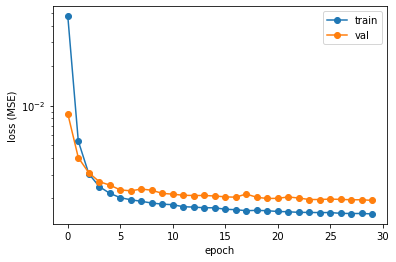

In [37]:
train_loss = model_trend.history.history['loss']
val_loss = model_trend.history.history['val_loss']

plt.plot(train_loss, '-o', label='train')
plt.plot(val_loss, '-o', label='val')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()
plt.show()

In [87]:
model_trend.load_weights('kevin-models/30d-all-100.h5')

In [88]:
y = model_trend.predict(X_test)
ave_mse = np.mean(np.square(y_test - y))
scale_factor = 1/scaler.scale_[0]   ## bring back to original scale
ave_mse *= scale_factor
print("Average MSE on testing data: %.3e" % ave_mse)

Average MSE on testing data: 2.610e-04


# Compare models

In [9]:
## model on just USD-EUR
model_1 = models.Sequential()
model_1.add(layers.GRU(100, return_sequences=True, input_shape=(100, 1)))
model_1.add(layers.GRU(100, return_sequences=True))
model_1.add(layers.GRU(100))
model_1.add(layers.Dense(10))
model_1.compile(optimizer='sgd', loss='mse')

model_1.load_weights('kevin-models/30d-single-100.h5')

In [10]:
## model on all data
model_2 = models.Sequential()
model_2.add(layers.GRU(100, return_sequences=True, input_shape=(100, 54)))
model_2.add(layers.GRU(100, return_sequences=True))
model_2.add(layers.GRU(100))
model_2.add(layers.Dense(10))
model_2.compile(optimizer='sgd', loss='mse')

model_2.load_weights('kevin-models/30d-all-100.h5')

In [11]:
model_3 = models.Sequential()
model_3.add(layers.Conv1D(32, 3, input_shape=(100, 1), activation='relu'))
model_3.add(layers.Conv1D(64, 3, activation='relu'))
model_3.add(layers.AveragePooling1D(pool_size=2,strides=2))
model_3.add(layers.Conv1D(128, 3, activation = 'relu')) 
model_3.add(layers.AveragePooling1D(pool_size=2,strides=2))
model_3.add(layers.Reshape((23*128,)))
model_3.add(layers.Dense(100, activation='relu'))
model_3.add(layers.Dense(10))
model_3.compile(optimizer='sgd', loss='mse')

model_3.load_weights('kevin-models/30d-conv.h5')

In [12]:
## ===== learning parameters ========================
learn_window = np.arange(100) ## learn from past 100 days
predict_window = np.arange(0, 30, 3) ## predict next 30 days, sampled 10 times
## ==================================================

In [13]:
## split into training and testing sets
## take 100 random windows, 50 for validation and 50 for testing
## all other non-overlapping data goes to testing.

#data = data_raw[:, 0:1] ## take only USD-EUR Close values
data = data_raw ## take all data
print("Data shape:", data.shape)

N, C = data.shape
L, P = len(learn_window), len(predict_window)
Lcap, Pcap = int(np.max(learn_window))+1, int(np.max(predict_window))+1
M = N - Lcap - Pcap

np.random.seed(999)
test_starts = np.random.randint(0, M, 50)
val_starts = np.random.randint(0, M, 50)

mask = np.ones(N)
for i in test_starts:
    mask[i+learn_window] = 0
for i in val_starts:
    mask[i+learn_window] = 0 
mask[np.arange(M, N)] = 0
train_starts = np.flatnonzero(mask)

print("Training size:", train_starts.shape[0])
print("Validation size:", val_starts.shape[0], "...", val_starts[:5])
print("Test size:", test_starts.shape[0], "...", test_starts[:5])

Data shape: (18628, 54)
Training size: 10759
Validation size: 50 ... [ 1286  7103  9451 16503 13300]
Test size: 50 ... [12636 13157 16865  5832  8417]


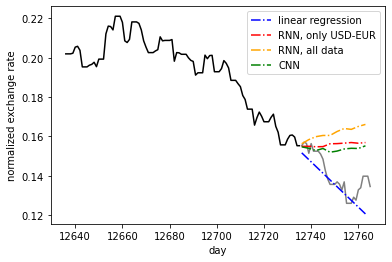

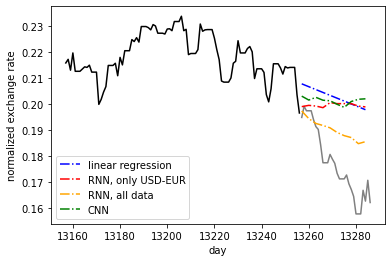

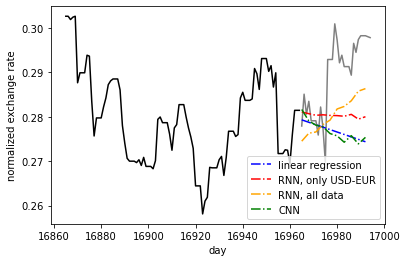

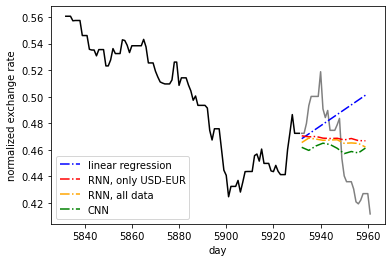

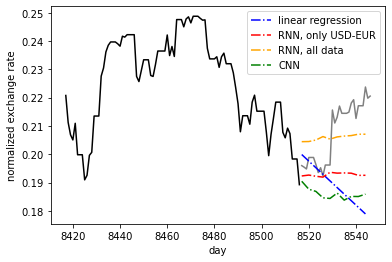

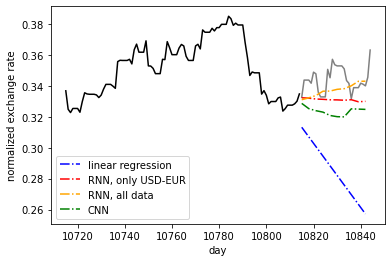

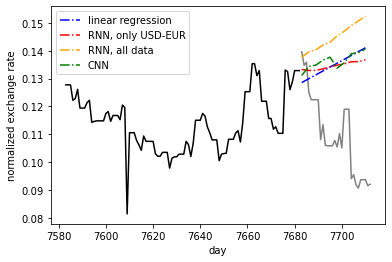

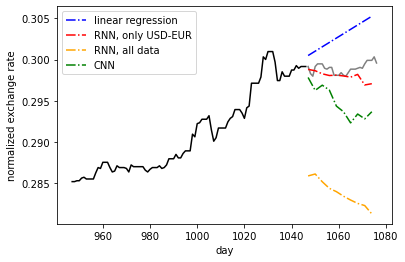

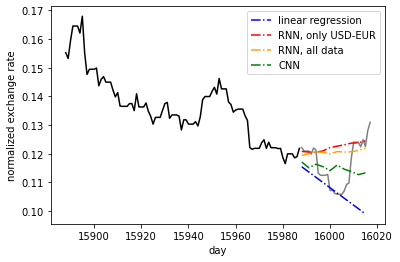

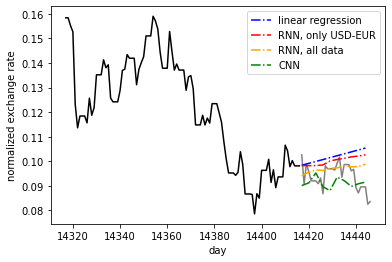

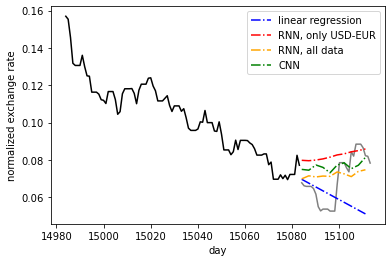

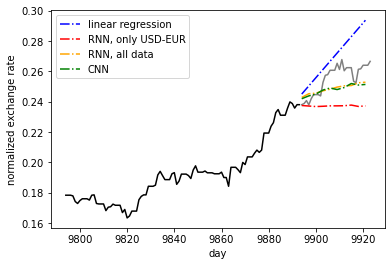

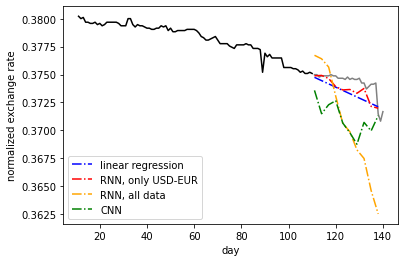

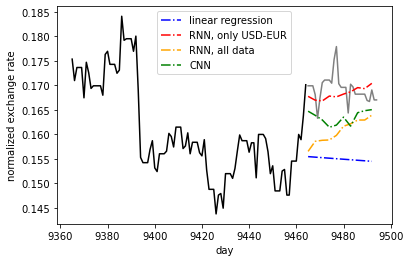

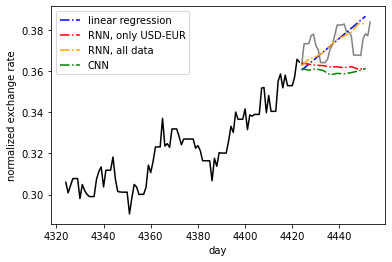

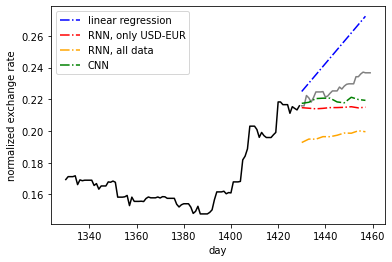

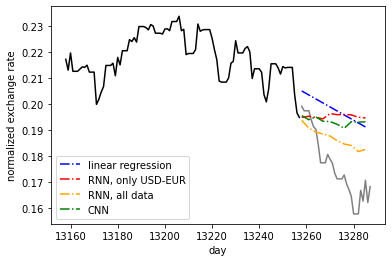

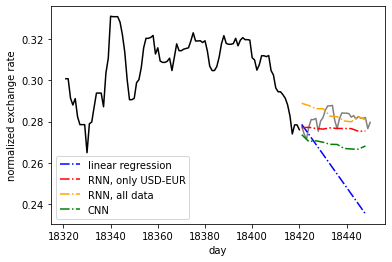

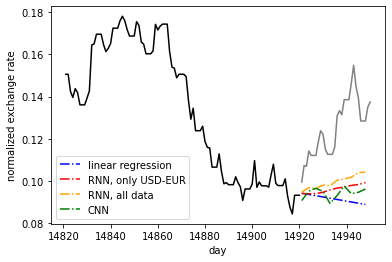

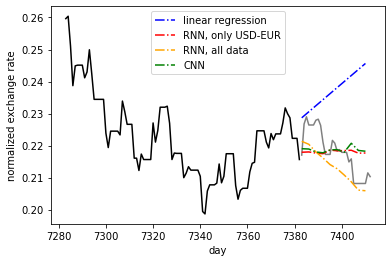

In [16]:
## visualize predictions

import sklearn.linear_model
import sklearn.preprocessing

actual_window = np.arange(30)

offset=70
lin_learn_window = np.arange(30)
lin_Lcap = 30

G = generate_all_regression(data, 1, learn_window, predict_window, test_starts)
for count, i in enumerate(test_starts):
    
    if count==20:
        break
    
    X, y = next(G)
    
    x_learn = i+learn_window
    x_actual = i+Lcap+actual_window
    
    y_learn = data[x_learn, 0]
    y_actual = data[x_actual, 0]
    
    X_single = X[:,:,0:1]
    y1_predict = model_1.predict(X_single)
    y2_predict = model_2.predict(X)
    y3_predict = model_3.predict(X_single)
    
    #mse = np.mean(np.square(y[0] - y_predict[0]))
    #scale_factor = 1/scaler.scale_[0]   ## bring back to original scale
    #mse *= scale_factor
    
    
    
    ## linear regression predictions
    lin_x_learn = (offset+i+lin_learn_window).reshape(-1, 1)
    lin_x_predict = (offset+i+lin_Lcap+predict_window).reshape(-1, 1)
    lin_y_learn = data[lin_x_learn[:, 0], 0:1]

    lin_model = sklearn.linear_model.LinearRegression()
    lin_model.fit(lin_x_learn, lin_y_learn)
    lin_y_predict = lin_model.predict(lin_x_predict)
    
    plt.plot(x_learn, y_learn, color='black')
    plt.plot(x_actual, y_actual, color='gray')
    plt.plot(x_actual[predict_window], lin_y_predict, '-.', color='blue', label='linear regression')
    plt.plot(x_actual[predict_window], y1_predict[0], '-.', color='red', label='RNN, only USD-EUR')
    plt.plot(x_actual[predict_window], y2_predict[0], '-.', color='orange', label='RNN, all data')
    plt.plot(x_actual[predict_window], y3_predict[0], '-.', color='green', label='CNN')

    #plt.title('average MSE: %.3e' % mse)
    plt.ylabel('normalized exchange rate')
    plt.xlabel('day')
    plt.legend()
    plt.show()

In [22]:
in_weight = model_2.layers[0].get_weights()[0]
a = np.mean(np.abs(in_weight), axis=1)
print(a)
print(np.argsort(a))

[0.09408287 0.0950005  0.09269454 0.09261271 0.09150247 0.0822621
 0.07608948 0.0762549  0.07793397 0.08115648 0.07850675 0.09279444
 0.06931347 0.08803874 0.08316081 0.0904116  0.09004719 0.08006343
 0.08286119 0.07374424 0.07645994 0.07872787 0.07976417 0.08027931
 0.07995039 0.08736168 0.08976763 0.08480209 0.08828143 0.08845863
 0.09100839 0.08119806 0.09370951 0.08309831 0.1044366  0.09596591
 0.09535302 0.06951262 0.09102394 0.07679639 0.07551239 0.09054478
 0.07520869 0.08772039 0.08077399 0.07517986 0.07366173 0.08121954
 0.0782688  0.08120186 0.10021712 0.09019958 0.09053054 0.08872285]
[12 37 46 19 45 42 40  6  7 20 39  8 48 10 21 22 24 17 23 44  9 31 49 47
  5 18 33 14 27 25 43 13 28 29 53 26 16 51 15 52 41 30 38  4  3  2 11 32
  0  1 36 35 50 34]


In [23]:
readcsv.get_data(cols=['Close'], verbose=True)

0 Data/000-EuroPerDollar(USDEUR).csv Close
1 Data/Bond-Germany2-yearNoteYield(IGDEU2D).csv Close
2 Data/Bond-Germany9-yearNoteYield(IGDEU9D).csv Close
3 Data/Bond-MoodyBAA(MOCBAAD).csv Close
4 Data/Bond-US10-yearBondYield(IGUSA10D).csv Close
5 Data/Bond-US2-yearNoteYield(IGUSA2D).csv Close
6 Data/Commod-GoldPrice(__XAU_D).csv Close
7 Data/Commod-OilPrice(__WTC_D).csv Close
8 Data/Commod-ReutersCRBIndex(_TRCCRBD).csv Close
9 Data/Commod-ReutersCRBIndustrialRaw(CMCRBIND).csv Close
10 Data/Commod-ReutersCRBmetal(CMCRBMED).csv Close
11 Data/Employ-EuropeUnemploymentRate(UNEUR19M).csv Close
12 Data/Employ-USInitialClaimsForUnemploymentInsurance(USICSAM).csv Close
13 Data/Employ-USTotalNonfarmPayroll(USPAYEMSM).csv Close
14 Data/Employ-USUnemploymentRate(UNUSAM).csv Close
15 Data/ExRate-DollarNominalEffectiveExchangeRate(XRNUSAM).csv Close
16 Data/ExRate-EuroNominalEffectiveExchangeRate(XRNEURM).csv Close
17 Data/ExRate-PoundPerDollar(USDGBP).csv Close
18 Data/ExRate-YenPerDollar(USDJPY).csv

array([[ 0.9811,  7.51  ,  7.49  , ...,  5.75  ,  3.67  ,  8.01  ],
       [ 0.9811,  7.51  ,  7.49  , ...,  5.75  ,  3.67  ,  7.92  ],
       [ 0.9814,  7.51  ,  7.49  , ...,  5.75  ,  3.67  ,  7.92  ],
       ...,
       [ 0.8163, -0.76  , -0.63  , ..., -0.769 ,  0.08  ,  0.1   ],
       [ 0.8131, -0.75  , -0.61  , ..., -0.794 ,  0.06  ,  0.08  ],
       [ 0.8185, -0.75  , -0.61  , ..., -0.794 ,  0.08  ,  0.09  ]])